# Investigating KDEs of popular architectures for Motif usage / sampling

# Imports

In [75]:
import copy
import time
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import datasets, transforms

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

In [131]:
alexnet = models.alexnet(pretrained=True)

In [5]:
feature0_pca = PCA(n_components=15, whiten=False)
feature0_data = feature0_pca.fit_transform(alexnet.features[0].weight.detach().numpy().reshape(-1, 11*11))
feature0_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(feature0_data)

In [6]:
feature3_pca = PCA(n_components=15, whiten=False)
feature3_data = feature3_pca.fit_transform(alexnet.features[3].weight.detach().numpy().reshape(-1, 5*5))
feature3_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(feature3_data)

In [53]:
class Motif(object):
    def __init__(self, data, downsample:int=15):
        self._pca = PCA(n_components=downsample, whiten=False) if downsample else None
        if self._pca is not None:
            transformed_data = self._pca.fit_transform(data)
            self._kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(transformed_data)
        else:
            self._kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data)
    
    def sample(self):
        kde_sample = self._kde.sample(1)
        return kde_sample if self._pca is None else self._pca.inverse_transform(self._kde.sample(1))

In [57]:
motif0 = Motif(alexnet.features[0].weight.detach().numpy().reshape(-1, 11*11))
motif3 = Motif(alexnet.features[3].weight.detach().numpy().reshape(-1, 5*5))
motif6 = Motif(alexnet.features[6].weight.detach().numpy().reshape(-1, 3*3), downsample=None)

In [56]:
loss = nn.MSELoss()
repetitions = 1000
sample_feature0 = lambda: feature0_pca.inverse_transform(feature0_kde.sample(1))
sample_feature3 = lambda: feature3_pca.inverse_transform(feature3_kde.sample(1))
print('Sample vs random normal\t\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(1, 121).normal_()) for _ in range(repetitions)]))
print('Sample vs random uniform\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(1, 121).uniform_()) for _ in range(repetitions)]))
print('Sample vs uniform(-0.8,0.8)\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(1, 121).uniform_(-0.8,0.8)) for _ in range(repetitions)]))
print('Sample vs uniform(-0.4,0.4)\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(1, 121).uniform_(-0.4,0.4)) for _ in range(repetitions)]))
print('Feature0 vs Feature0\t\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(sample_feature0())) for _ in range(repetitions)]))

sample_feature3in0 = lambda: feature0_pca.inverse_transform(feature3_kde.sample(1))
sample_feature0in3 = lambda: feature3_pca.inverse_transform(feature0_kde.sample(1))
print('Feature0 vs Feature3in0\t\t', np.mean([loss(torch.FloatTensor(sample_feature0()), torch.FloatTensor(sample_feature3in0())) for _ in range(repetitions)]))
print('Feature3 vs Feature0in3\t\t', np.mean([loss(torch.FloatTensor(sample_feature3()), torch.FloatTensor(sample_feature0in3())) for _ in range(repetitions)]))

print('Feature6 vs Feature6\t\t', np.mean([loss(torch.FloatTensor(motif6.sample()), torch.FloatTensor(motif6.sample())) for _ in range(repetitions)]))
print('Feature6 vs uniform(-0.4,0.4)\t', np.mean([loss(torch.FloatTensor(motif6.sample()), torch.FloatTensor(1, 9).uniform_(-0.4,0.4)) for _ in range(repetitions)]))


Sample vs random normal		 1.0252208
Sample vs random uniform	 0.3491165
Sample vs uniform(-0.8,0.8)	 0.2294704
Sample vs uniform(-0.4,0.4)	 0.0689206
Feature0 vs Feature0		 0.031253207
Feature0 vs Feature3in0		 0.020539014
Feature3 vs Feature0in3		 0.100704215
Feature6 vs Feature6		 0.08165892
Feature6 vs uniform(-0.4,0.4)	 0.09314346


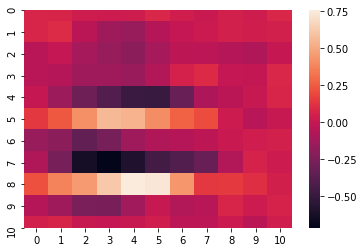

In [20]:
sns.heatmap(sample_feature0().reshape(11, 11))

In [140]:
def disable_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False
disable_parameter_requires_grad(alexnet)
num_classes = 10
alexnet.classifier[6] = nn.Linear(4096, num_classes)

In [133]:
input_size = 224
batch_size = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # first, convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize inputs for cifar
    #transforms.Normalize((0.1307,), (0.3081,))  # normalize inputs for mnist
])
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),  # first, convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize((0.1307,), (0.3081,))  # normalize inputs for mnist
])

cifar10_dataset_root = '/media/data/set/cifar10'
cifar10_train_set = datasets.CIFAR10(root=cifar10_dataset_root, train=True, download=True, transform=train_transform)
cifar10_test_set = datasets.CIFAR10(root=cifar10_dataset_root, train=False, download=True, transform=test_transform)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=batch_size, shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=batch_size, shuffle=True)

"""
# download and transform train dataset
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/data/set/mnist/',
    download=True,
    train=True,
    transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

# download and transform test dataset
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/data/set/mnist/',
    download=True,
    train=False,
    transform=test_transform),
    batch_size=batch_size,
    shuffle=True)
"""

Files already downloaded and verified
Files already downloaded and verified


"\n# download and transform train dataset\nmnist_train_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('/media/data/set/mnist/',\n    download=True,\n    train=True,\n    transform=train_transform),\n    batch_size=batch_size,\n    shuffle=True)\n\n# download and transform test dataset\nmnist_test_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('/media/data/set/mnist/',\n    download=True,\n    train=False,\n    transform=test_transform),\n    batch_size=batch_size,\n    shuffle=True)\n"

In [130]:
device

device(type='cpu')

In [70]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [80]:
params_to_update = []
for name, param in alexnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.SGD(params_to_update, lr=0.01, momentum=0.5)
loss_func = nn.CrossEntropyLoss()

alexnet.to(device)

dataloaders_dict = {
    'train': cifar10_train_loader,
    'val': cifar10_test_loader
}

model_ft, hist = train_model(
    alexnet,
    dataloaders_dict,
    loss_func,
    optimizer,
    num_epochs=5,
    is_inception=False
)


Epoch 0/4
----------
train Loss: 1.4601 Acc: 0.4736
val Loss: 0.8935 Acc: 0.6844

Epoch 1/4
----------
train Loss: 1.3626 Acc: 0.5112
val Loss: 0.8448 Acc: 0.6997

Epoch 2/4
----------
train Loss: 1.3380 Acc: 0.5237
val Loss: 0.7918 Acc: 0.7240

Epoch 3/4
----------
train Loss: 1.3314 Acc: 0.5242
val Loss: 0.8106 Acc: 0.7157

Epoch 4/4
----------
train Loss: 1.3227 Acc: 0.5257
val Loss: 0.8124 Acc: 0.7131

Training complete in 33m 34s
Best val Acc: 0.724000


In [136]:
trained_alexnet_features3_weight = np.copy(model_ft.features[3].weight)
trained_alexnet_features3_weight.shape

(192, 64, 5, 5)

In [137]:
motif3.sample().shape

(1, 25)

In [138]:
sampled_features3_weight = np.stack([np.stack([motif3.sample().reshape(5, 5) for _ in range(64)]) for _ in range(192)])
sampled_features3_weight.shape

(192, 64, 5, 5)

In [141]:
# Assign samples feature weight to model
disable_parameter_requires_grad(model_ft)
model_ft.features[3].weight = nn.Parameter(torch.FloatTensor(sampled_features3_weight), requires_grad=False)

In [142]:
# Set the succeeding layer to be learnable
model_ft.features[6].weight.requires_grad = True

In [103]:
# Re-validate model
model = model_ft
optimizer = torch.optim.SGD(params_to_update, lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
running_corrects = 0

model.eval()  # Set model to evaluating-stage

dataloader = cifar10_test_loader

# Iterate over data.
for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / len(dataloader.dataset)
epoch_acc = running_corrects.double() / len(dataloader.dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format('Validation', epoch_loss, epoch_acc))

Validation Loss: 3.6768 Acc: 0.0956


In [143]:
model = model_ft

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print('Parameters to update:')
print([p.shape for p in params_to_update])

model.to(device)

model_ft2, hist2 = train_model(
    model,
    dataloaders_dict,
    loss_func,
    optimizer,
    num_epochs=5,
    is_inception=False
)


Parameters to update:
[torch.Size([384, 192, 3, 3]), torch.Size([10, 4096]), torch.Size([10])]
Epoch 0/4
----------
train Loss: 2.3513 Acc: 0.0948
val Loss: 2.3446 Acc: 0.0930

Epoch 1/4
----------
train Loss: 2.3516 Acc: 0.0942
val Loss: 2.3446 Acc: 0.0930

Epoch 2/4
----------
train Loss: 2.3510 Acc: 0.0941
val Loss: 2.3446 Acc: 0.0930

Epoch 3/4
----------
train Loss: 2.3511 Acc: 0.0941
val Loss: 2.3446 Acc: 0.0930

Epoch 4/4
----------
train Loss: 2.3517 Acc: 0.0943
val Loss: 2.3446 Acc: 0.0930

Training complete in 48m 12s
Best val Acc: 0.093000
